In [3]:
using Revise 
using EuclidianNormalizingFlows

using BAT
using Distributions
using Optimisers
using FunctionChains
using ArraysOfArrays
using LinearAlgebra
using ValueShapes
using StatsBase
using FileIO
using JLD2
using CUDA
using CUDAKernels
using KernelAbstractions
using Flux
using PyPlot
using Images

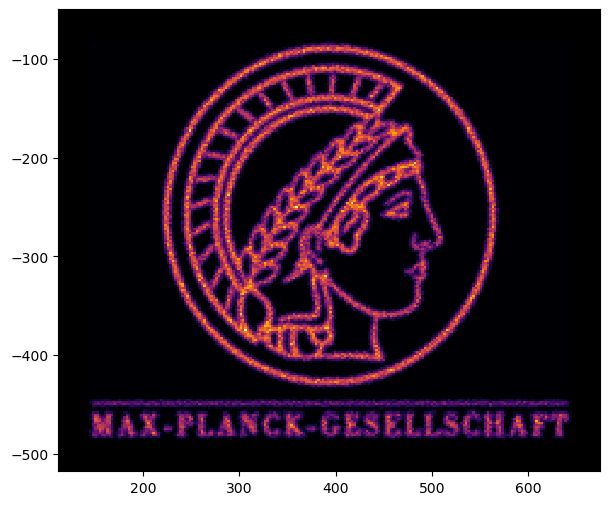

CUDADevice()

In [99]:
_device = KernelAbstractions.get_device(CUDA.rand(10)) 

mpg = load("/home/iwsatlas1/mdud/ACS/EuclidianNormalizingFlows.jl/mpg_logo.png");
im = Gray.(mpg)
position_mask = Float64.(im) .< 1
lines = findall(position_mask)
line_ids = getfield.(lines, :I)
raw_samples = [0 1; -1 0] * hcat(collect.(line_ids)...) 
raw_samples = hcat(fill(raw_samples, 10)...) 
raw_samples += 2 .* randn(2, size(raw_samples, 2))
fig, ax = plt.subplots(1,1, figsize=(7,6))
ax.hist2d(raw_samples[1,:], raw_samples[2,:], [200,200], cmap="inferno")
ax.set_xlim([minimum(raw_samples[1,:])-30, maximum(raw_samples[1,:])+30])
ax.set_ylim([minimum(raw_samples[2,:])-30, maximum(raw_samples[2,:])+30])
ax.set_facecolor("black")

smpls_flat = gpu(raw_samples);
samples_nested = nestedview(gpu(smpls_flat)); 
_device =KernelAbstractions.get_device(CUDA.rand(10))


In [445]:
_device

CUDADevice()

In [54]:
n_smpls = 10^5

prposed_dims = [2,4,8,10,20,40,80,100,200,500]

n_dims = 2
n_modes = 10

mvns = [MvNormal(10 .*rand(n_dims), 0.5 * abs(randn(1)[1]) .* I(n_dims)) for i in 1:n_modes]
d = MixtureModel(mvns)
importance_density = MvNormal(zeros(n_dims), I)
wanna_use_GPU = true
_device = wanna_use_GPU ? KernelAbstractions.get_device(CUDA.rand(10)) : KernelAbstractions.get_device(rand(10))
samples = bat_sample(d, BAT.IIDSampling(nsamples=n_smpls)).result;
smpls_flat = gpu(flatview(unshaped.(samples.v)));
samples_nested = wanna_use_GPU ? nestedview(gpu(smpls_flat)) : nestedview(smpls_flat);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/iwsatlas1/mdud/ACS/BAT.jl/src/algotypes/bat_default.jl:44


+++ Starting round 1
+++ Starting round 2
576.939951 seconds (86.18 M allocations: 2.562 TiB, 12.37% gc time)


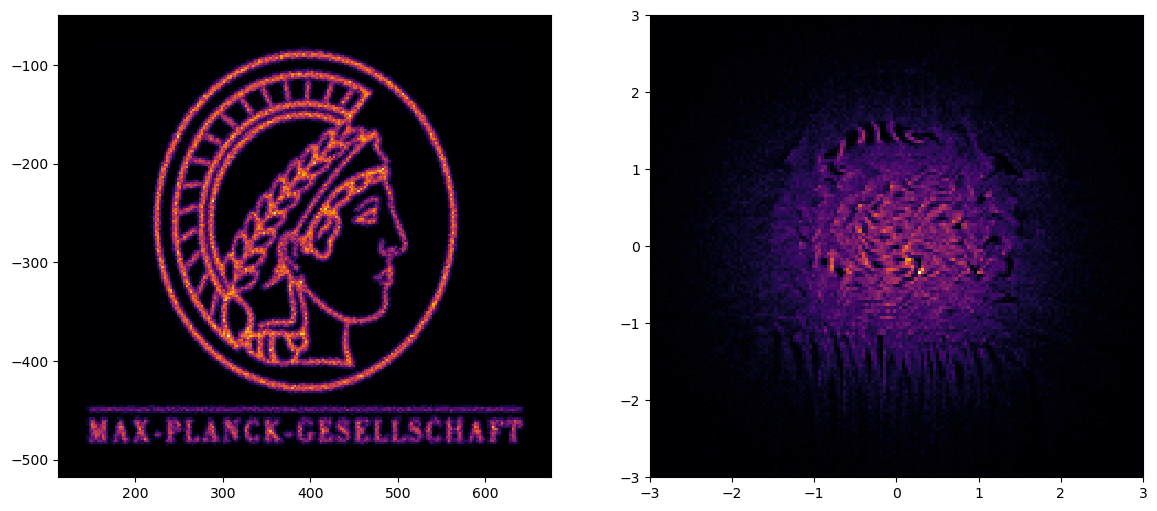

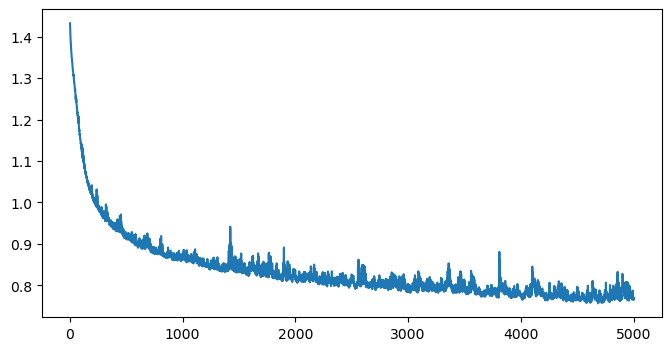

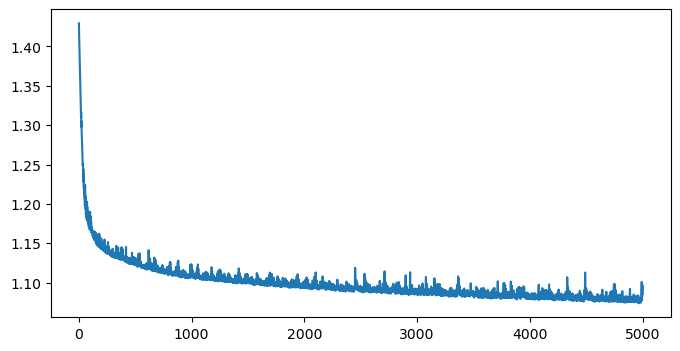

In [118]:
nbatches = 10
nepochs = 500
K = 120

blocks = get_flow_musketeer(2,_device,K)
lr = fill(4f-3, length(blocks.fs))
trained_blocks = Function[AdaptiveScaleShift()]
hists = Vector[]

smpls_train = samples_nested;

@time begin
    smpls_train = nestedview(gpu(trained_blocks[1](smpls_flat)))
    
    for i in 1:2
        println("+++ Starting round $i")
        
        r = optimize_whitening(smpls_train, 
            blocks.fs[1+i],
            Optimisers.Adam(lr[i]),
            nbatches=nbatches,
            nepochs=nepochs, 
            shuffle_samples =false)
            
        trained_trafo = r.result
        push!(trained_blocks, trained_trafo)
        push!(hists, r.negll_history)
        smpls_train = nestedview(trained_trafo(flatview(smpls_train)))
    end
end

push!(trained_blocks, AdaptiveScaleShift())
trained_flow = fchain(trained_blocks)

smpls_transformed = trained_flow(smpls_flat)

smpls_transformed = cpu(smpls_transformed)
smpls_flat_cpu = cpu(smpls_flat)

fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[1].hist2d(smpls_flat_cpu[1,:], smpls_flat_cpu[2,:], [200,200], cmap="inferno")
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:])-30, maximum(smpls_flat_cpu[1,:])+30])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30])
ax[1].set_facecolor("black")
ax[2].hist2d(smpls_transformed[1,:], smpls_transformed[2,:], [200,200], cmap="inferno")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])

for i in 1:length(hists)
    fig2, ax2 = plt.subplots(1, figsize=(8,4))
    ax2.plot(1:length(hists[i]), hists[i])
end

+++ Starting round 1
+++ Starting round 2
1534.627375 seconds (138.53 M allocations: 5.100 TiB, 13.72% gc time)


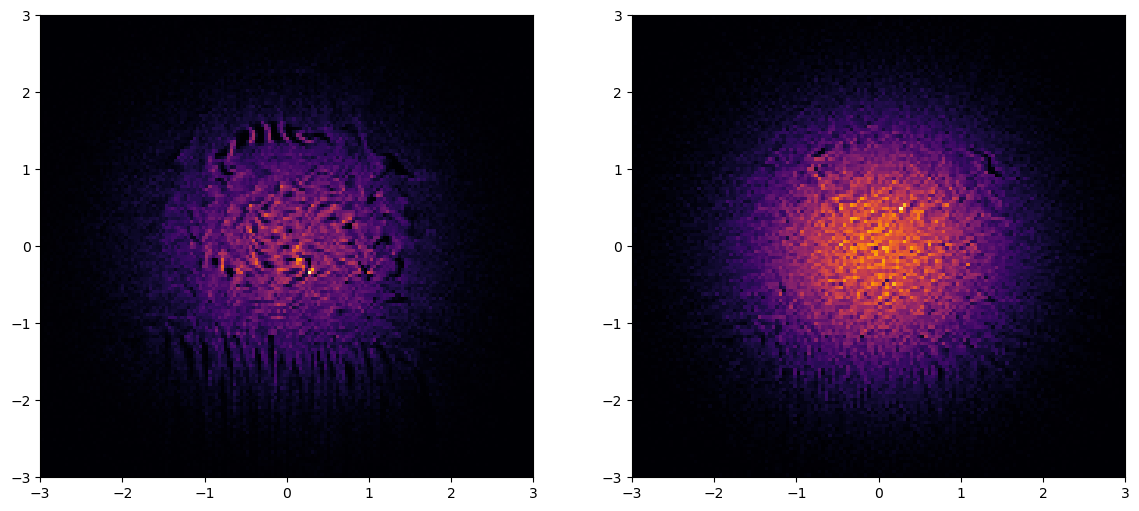

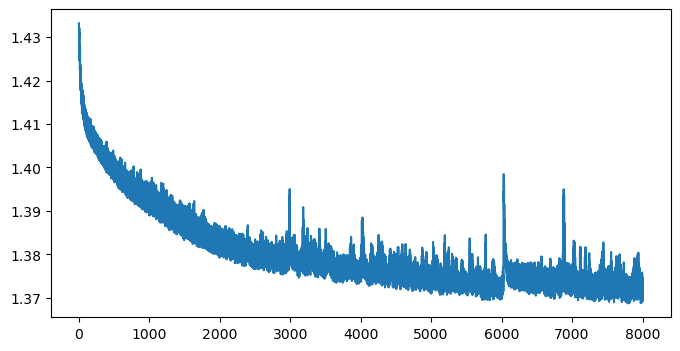

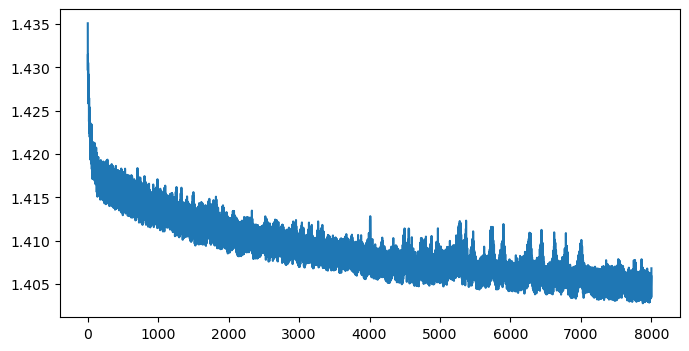

In [123]:
nbatches = 10
nepochs = 800
K = 150

blocks = get_flow_musketeer(2,_device,K)
lr = fill(5f-3, length(blocks.fs))
trained_blocks_2 = Function[AdaptiveScaleShift()]
hists_2 = Vector[]


@time begin
    smpls_train = nestedview(trained_blocks_2[1](gpu(smpls_transformed)))
    
    for i in 1:2
        println("+++ Starting round $i")
        
        r = optimize_whitening(smpls_train, 
            blocks.fs[1+i],
            Optimisers.Adam(lr[i]),
            nbatches=nbatches,
            nepochs=nepochs, 
            shuffle_samples =false)
            
        trained_trafo_2 = r.result
        push!(trained_blocks_2, trained_trafo_2)
        push!(hists_2, r.negll_history)
        smpls_train = nestedview(trained_trafo_2(flatview(smpls_train)))
    end
end

push!(trained_blocks_2, AdaptiveScaleShift())
trained_flow_2 = fchain(trained_blocks_2)
smpls_transformed_2 = trained_flow_2(gpu(smpls_transformed))

smpls_transformed_2 = cpu(smpls_transformed_2)
smpls_flat_cpu = cpu(smpls_flat)

fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[1].hist2d(smpls_transformed[1,:], smpls_transformed[2,:], [200,200], cmap="inferno")
ax[1].set_xlim([-3, 3])
ax[1].set_ylim([-3, 3])
ax[2].hist2d(smpls_transformed_2[1,:], smpls_transformed_2[2,:], [200,200], cmap="inferno")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])


for i in 1:length(hists_2)
    fig2, ax2 = plt.subplots(1, figsize=(8,4))
    ax2.plot(1:length(hists_2[i]), hists_2[i])
end

+++ Starting round 1
+++ Starting round 2
1789.950599 seconds (138.54 M allocations: 5.100 TiB, 14.36% gc time)


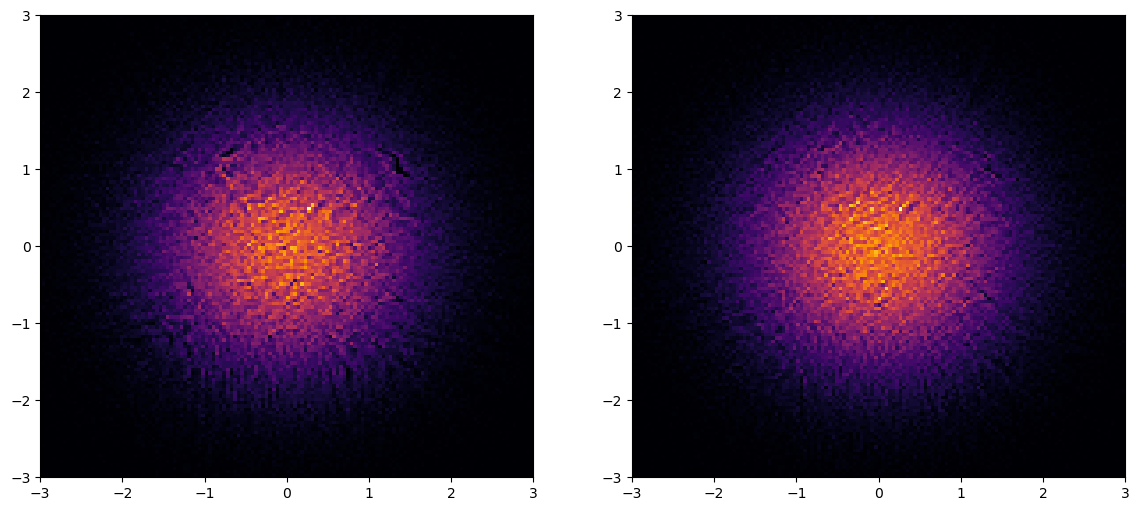

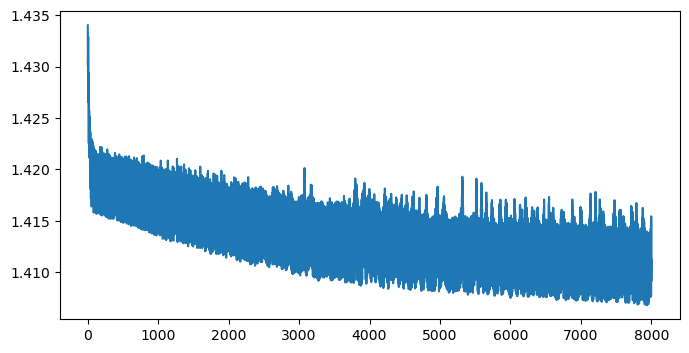

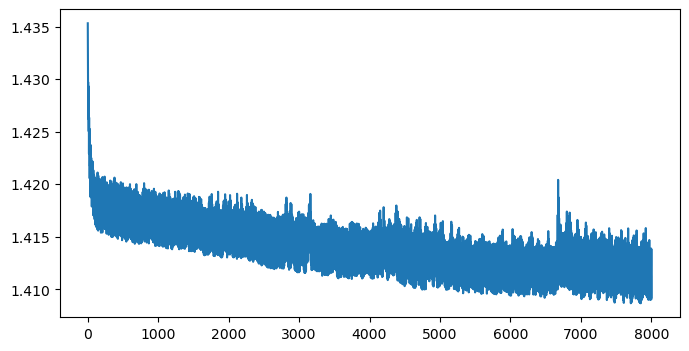

In [128]:
nbatches = 10
nepochs = 800
K = 150

blocks = get_flow_musketeer(2,_device,K)
lr = fill(5f-3, length(blocks.fs))
trained_blocks_3 = Function[AdaptiveScaleShift()]
hists_3 = Vector[]


@time begin
    smpls_train = nestedview(trained_blocks_3[1](gpu(smpls_transformed_2)))
    
    for i in 1:2
        println("+++ Starting round $i")
        
        r = optimize_whitening(smpls_train, 
            blocks.fs[1+i],
            Optimisers.Adam(lr[i]),
            nbatches=nbatches,
            nepochs=nepochs, 
            shuffle_samples =false)
            
        trained_trafo_3 = r.result
        push!(trained_blocks_3, trained_trafo_3)
        push!(hists_3, r.negll_history)
        smpls_train = nestedview(trained_trafo_3(flatview(smpls_train)))
    end
end

push!(trained_blocks_3, AdaptiveScaleShift())
trained_flow_3 = fchain(trained_blocks_3)
smpls_transformed_3 = trained_flow_3(gpu(smpls_transformed_2))

smpls_transformed_3 = cpu(smpls_transformed_3)
smpls_flat_cpu = cpu(smpls_flat)

fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[1].hist2d(smpls_transformed_2[1,:], smpls_transformed_2[2,:], [200,200], cmap="inferno")
ax[1].set_xlim([-3, 3])
ax[1].set_ylim([-3, 3])
ax[2].hist2d(smpls_transformed_3[1,:], smpls_transformed_3[2,:], [200,200], cmap="inferno")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])


for i in 1:length(hists_3)
    fig2, ax2 = plt.subplots(1, figsize=(8,4))
    ax2.plot(1:length(hists_3[i]), hists_3[i])
end

# MPG

In [150]:
mpg_flow = fchain([trained_flow.fs..., trained_flow_2.fs..., trained_flow_3.fs...])

FunctionChain(12-element Vector{Function}:
 (::AdaptiveScaleShift) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::AdaptiveScaleShift) (generic function with 2 methods)
 (::AdaptiveScaleShift) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::AdaptiveScaleShift) (generic function with 2 methods)
 (::AdaptiveScaleShift) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::AdaptiveScaleShift) (generic function with 2 methods))

In [151]:
smpls_transformed_4 = cpu(mpg_flow(gpu(smpls_flat)))

2×318630 Matrix{Float32}:
 -3.1599    -2.60691  -3.12894  -2.86085  …   2.76706   2.58062   2.53667
 -0.986757  -1.06691  -1.14158  -1.20821     -1.60085  -1.73729  -1.91509

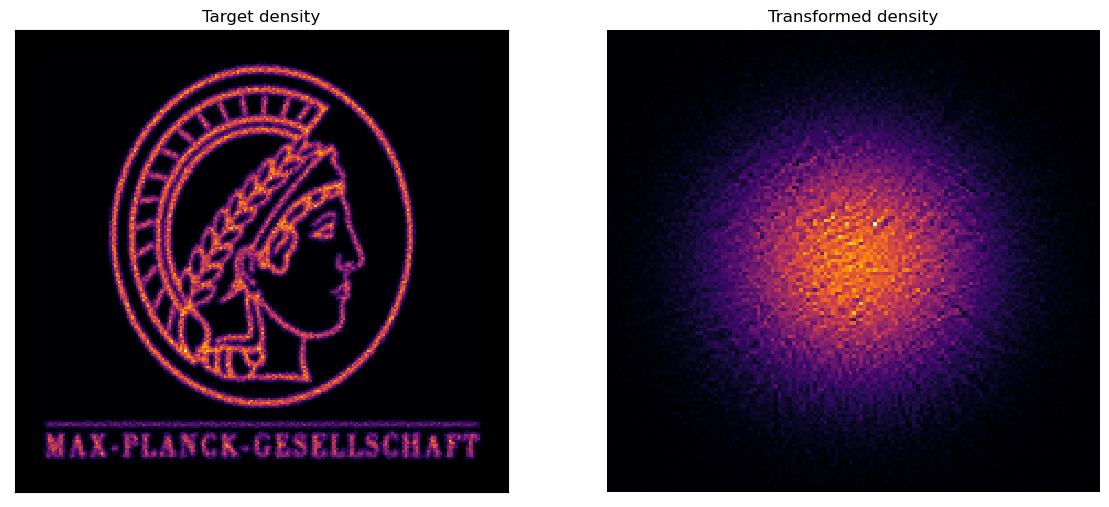

(-3.0, 3.0)

In [152]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[1].set_title("Target density")
ax[1].hist2d(smpls_flat_cpu[1,:], smpls_flat_cpu[2,:], [200,200], cmap="inferno")
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:])-30, maximum(smpls_flat_cpu[1,:])+30])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30])
ax[1].set_facecolor("black")
ax[1].get_xaxis().set_visible(false)
ax[1].get_yaxis().set_visible(false)
ax[2].hist2d(smpls_transformed_4[1,:], smpls_transformed_4[2,:], [200,200], cmap="inferno")
ax[2].set_title("Transformed density")
ax[2].axis("off")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])

In [166]:
normals = bat_sample(MvNormal(I(2)), BAT.IIDSampling(nsamples=3.5 * 10^5)).result;
normals_flat = flatview(unshaped.(normals.v))

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/iwsatlas1/mdud/ACS/BAT.jl/src/algotypes/bat_default.jl:44


2×350000 Matrix{Float64}:
 -0.45714   0.0455378   1.74461   …   0.00182152  -0.0640079  -1.22055
 -0.127674  0.631285   -0.126344     -1.10341      0.668376    0.22532

In [167]:
synthetic_samples = inverse(cpu.(mpg_flow))(normals_flat)

2×350000 Matrix{Float64}:
  293.598   399.15    561.765   253.659  …   391.9   391.887   247.609
 -301.9    -198.724  -278.869  -205.648     -446.2  -192.47   -256.105

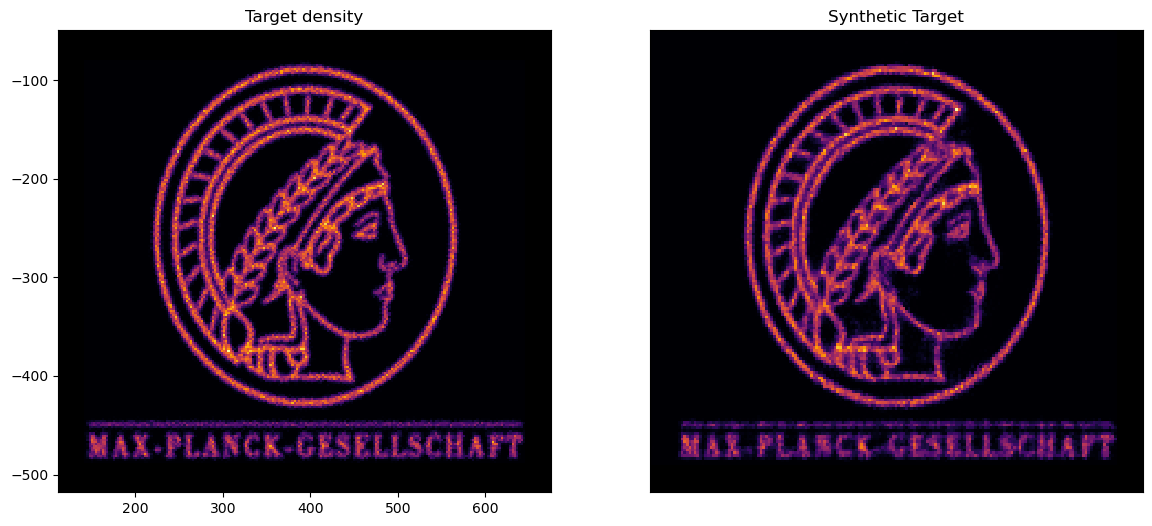

(-518.005859375, -49.408912658691406)

In [184]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[1].set_title("Target density")
ax[1].hist2d(smpls_flat_cpu[1,:], smpls_flat_cpu[2,:], [200,200], cmap="inferno")
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:])-30, maximum(smpls_flat_cpu[1,:])+30])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30])
ax[1].set_facecolor("black")
#ax[1].get_xaxis().set_visible(false)
#ax[1].get_yaxis().set_visible(false)
ax[2].hist2d(synthetic_samples[1,:], synthetic_samples[2,:], [200, 200], cmap="inferno")
ax[2].set_title("Synthetic Target")
ax[2].get_xaxis().set_visible(false)
ax[2].get_yaxis().set_visible(false)
ax[2].set_facecolor("black")

ax[2].set_xlim([minimum(smpls_flat_cpu[1,:])-30, maximum(smpls_flat_cpu[1,:])+30])
ax[2].set_ylim([minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30])


In [180]:
minimum(smpls_flat_cpu[1,:])-30 ,  maximum(smpls_flat_cpu[1,:])+30

(111.38846f0, 675.3618f0)

In [183]:
(maximum(smpls_flat_cpu[1,:]) - minimum(smpls_flat_cpu[1,:])) /2

251.98668f0

In [181]:
minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30

(-518.00586f0, -49.408913f0)

In [365]:
pd = 10000
ys = collect(range(-50, -550, pd))
xs = collect(range(100, 700, pd))
ts = 25

grid_points = [150 150; -510 -510]
lc = 0 

for x in 100:ts:700
    grid_points = hcat(grid_points, vcat(fill(x, 1, pd), reshape(ys, 1, length(ys))))    
    lc += 1
end

for y in -550:ts:(-50)
    grid_points = hcat(grid_points, vcat(reshape(xs, 1, length(xs)), fill(y, 1, pd)))
    lc+=1
end

In [366]:
grid_points

2×460002 Matrix{Float64}:
  150.0   150.0  100.0  100.0   100.0  …  699.82  699.88  699.94  700.0
 -510.0  -510.0  -50.0  -50.05  -50.1     -50.0   -50.0   -50.0   -50.0

In [367]:
transformed_grid_points = cpu.(mpg_flow)(grid_points)

2×460002 Matrix{Float64}:
 -2.11175  -2.11175  -4.98302  …  4.8835   4.8835   4.8835   4.8835
 -4.34078  -4.34078   4.96357     4.98641  4.98641  4.98641  4.98641

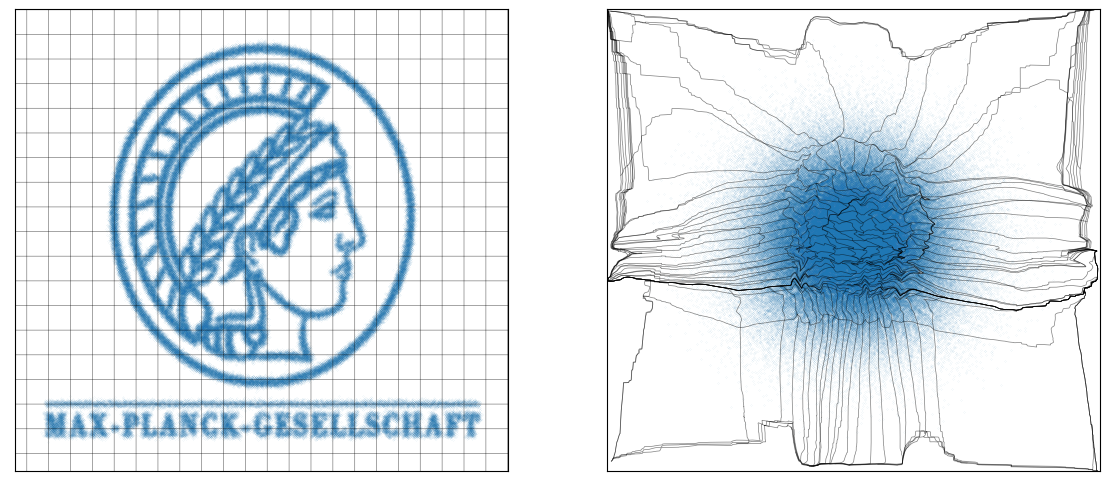

In [368]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
for i in 1:Integer(lc)
    ax[1].plot(grid_points[1,3+(i-1)*pd:2+i*pd], grid_points[2,3+(i-1)*pd:2+i*pd], alpha = 0.5, color = "black", linewidth=0.5)
end
ax[1].scatter(smpls_flat_cpu[1,:], smpls_flat_cpu[2,:], s = 0.0008)
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:])-30, maximum(smpls_flat_cpu[1,:])+30])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30])
ax[1].get_xaxis().set_visible(false)
ax[1].get_yaxis().set_visible(false)

for i in 1:Integer(lc)
    ax[2].plot(transformed_grid_points[1,3+(i-1)*pd:2+i*pd], transformed_grid_points[2,3+(i-1)*pd:2+i*pd], alpha = 0.5, color = "black", linewidth=0.5)
end
ax[2].scatter(smpls_transformed_4[1,:], smpls_transformed_4[2,:], s = 0.0008)
ax[2].set_xlim([-5, 5])
ax[2].set_ylim([-5, 5])
ax[2].get_xaxis().set_visible(false)
ax[2].get_yaxis().set_visible(false)

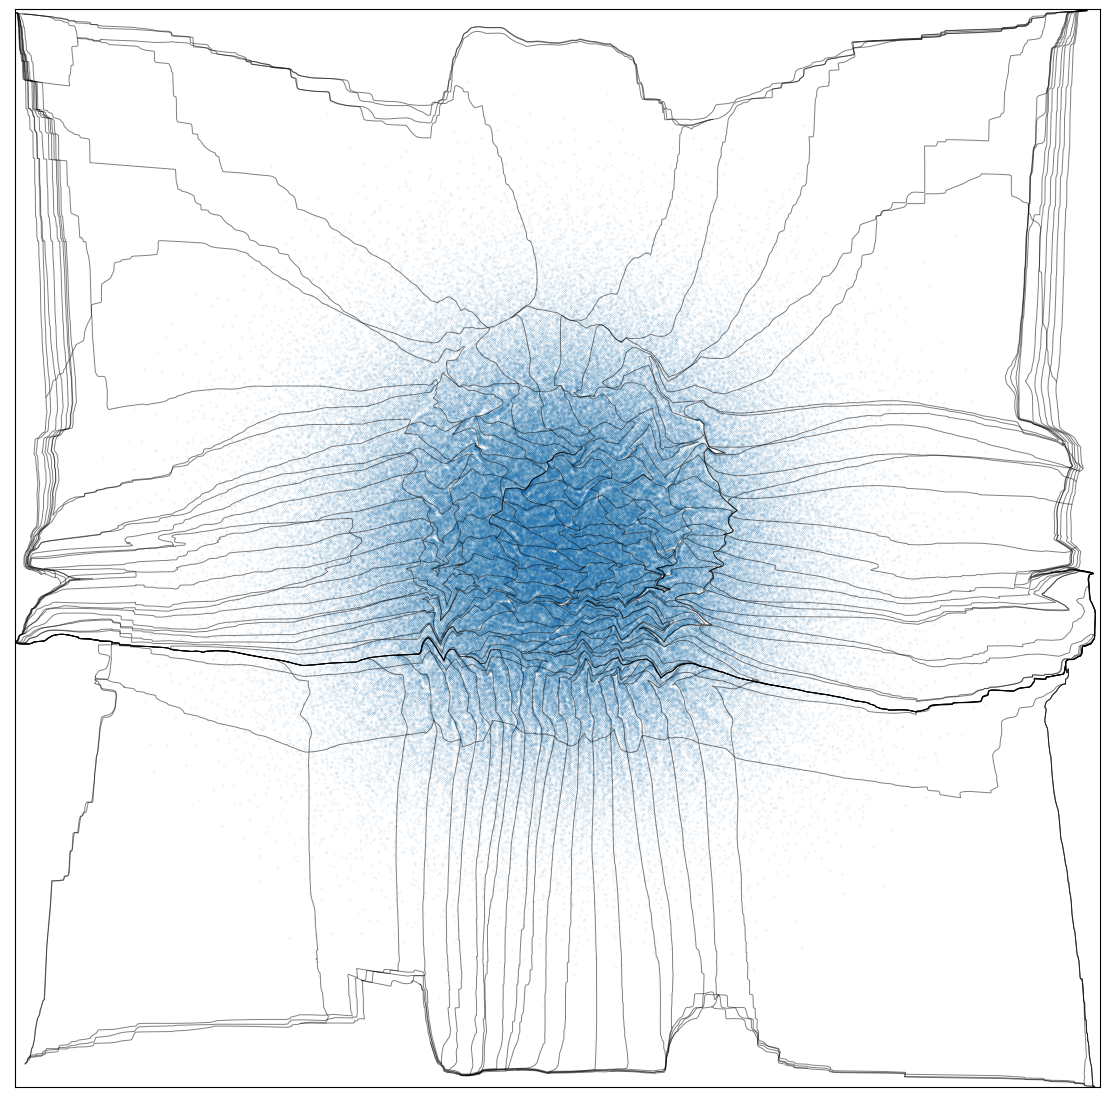

In [369]:
fig, ax = plt.subplots(1,1, figsize=(14,14))
for i in 1:Integer(lc)
    ax.plot(transformed_grid_points[1,3+(i-1)*pd:2+i*pd], transformed_grid_points[2,3+(i-1)*pd:2+i*pd], alpha = 0.5, color = "black", linewidth=0.7)
end
ax.scatter(smpls_transformed_4[1,:], smpls_transformed_4[2,:], s = 0.003)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.get_xaxis().set_visible(false)
ax.get_yaxis().set_visible(false)

In [356]:
pd_n = 10000
ys_n = collect(range(-5, 5, pd_n))
xs_n = collect(range(-5, 5, pd_n))
ts_n = 0.25

grid_points_normal = [4 4; -4 -4]
lc_n = 0 

for x in -4:ts_n:4
    grid_points_normal = hcat(grid_points_normal, vcat(fill(x, 1, pd_n), reshape(ys_n, 1, length(ys_n))))    
    lc_n += 1
end

for y in -4:ts_n:4
    grid_points_normal = hcat(grid_points_normal, vcat(reshape(xs_n, 1, length(xs_n)), fill(y, 1, pd_n)))
    lc_n +=1
end

In [357]:
grid_points_normal

2×660002 Matrix{Float64}:
  4.0   4.0  -4.0  -4.0    -4.0    -4.0    …  4.996  4.997  4.998  4.999  5.0
 -4.0  -4.0  -5.0  -4.999  -4.998  -4.997     4.0    4.0    4.0    4.0    4.0

In [358]:
grid_points_normal_transformed = inverse(cpu(mpg_flow))(grid_points_normal)

2×660002 Matrix{Float64}:
  639.013   639.013   540.481   540.467  …  866.668   866.765   866.862
 -487.85   -487.85   -854.688  -854.607     -88.8732  -88.8648  -88.8564

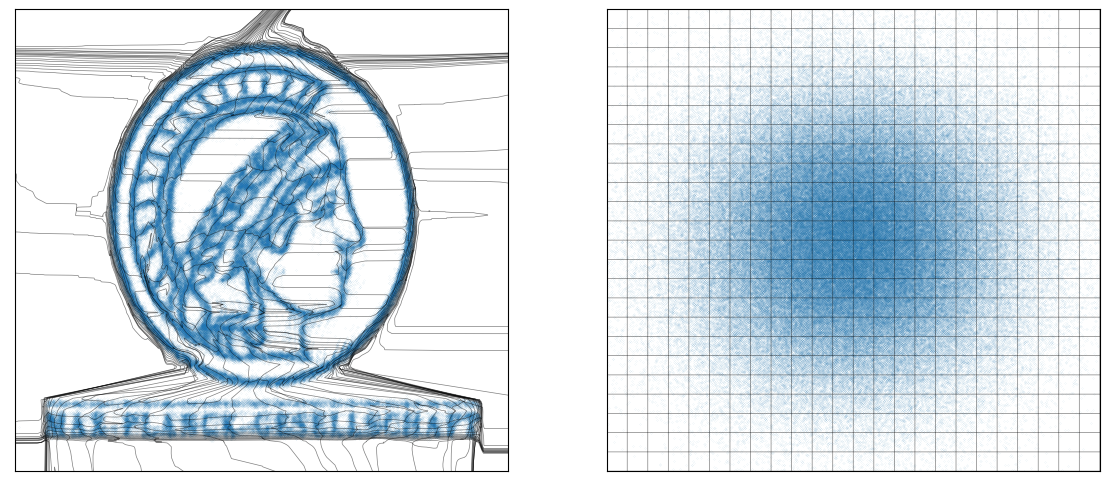

In [359]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
for i in 1:Integer(lc_n)
    ax[1].plot(grid_points_normal_transformed[1,3+(i-1)*pd_n:2+i*pd_n], grid_points_normal_transformed[2,3+(i-1)*pd_n:2+i*pd_n], alpha = 0.5, color = "black", linewidth=0.5)
end
ax[1].scatter(synthetic_samples[1,:], synthetic_samples[2,:], s = 0.0008)
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:])-30, maximum(smpls_flat_cpu[1,:])+30])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30])
ax[1].get_xaxis().set_visible(false)
ax[1].get_yaxis().set_visible(false)

for i in 1:Integer(lc_n)
    ax[2].plot(grid_points_normal[1,3+(i-1)*pd_n:2+i*pd_n], grid_points_normal[2,3+(i-1)*pd_n:2+i*pd_n], alpha = 0.5, color = "black", linewidth=0.5)
end
ax[2].scatter(normals_flat[1,:], normals_flat[2,:], s = 0.0008)
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])
ax[2].get_xaxis().set_visible(false)
ax[2].get_yaxis().set_visible(false)

In [432]:
Pkg.add("PlotlyJS")

   Resolving package versions...
   Installed Pidfile ─────────────── v1.3.0
   Installed PlotlyBase ──────────── v0.8.19
   Installed AssetRegistry ───────── v0.1.0
   Installed URIParser ───────────── v0.4.1
   Installed BinDeps ─────────────── v1.0.2
   Installed HTTP ────────────────── v0.9.17
   Installed Hiccup ──────────────── v0.2.2
   Installed Lazy ────────────────── v0.15.1
   Installed Kaleido_jll ─────────── v0.2.1+0
   Installed Mustache ────────────── v1.0.14
   Installed WebSockets ──────────── v1.5.9
   Installed Blink ───────────────── v0.12.5
   Installed Widgets ─────────────── v0.6.6
   Installed JSExpr ──────────────── v0.5.4
   Installed FunctionalCollections ─ v0.5.0
   Installed PlotlyJS ────────────── v0.18.10
   Installed Mux ─────────────────── v0.7.6
   Installed Observables ─────────── v0.5.2
   Installed WebIO ───────────────── v0.8.18
    Updating `~/ACS/EuclidianNormalizingFlows.jl/Project.toml`
  [f0f68f2c] + PlotlyJS v0.18.10
    Updating `~/ACS/Eucli

In [433]:
using PlotlyJS

WebIO._IJuliaInit()

In [435]:
  
PlotlyJS.plot([

    PlotlyJS.scatter(
        x=grid_points_normal_transformed[1,3+(i-1)*pd_n:2+i*pd_n], y=grid_points_normal_transformed[2,3+(i-1)*pd_n:2+i*pd_n], type="scatter", mode="lines", name="Plotly spline",
        line=attr(color="green", width=2, shape="spline")
    ),

    ], Layout(scene=attr(aspectmode="data"), showlegend=true)
)

data: [
  "scatter with fields line, mode, name, type, x, and y"
]

layout: "layout with fields margin, scene, showlegend, and template"

In [431]:
i = 20
x = grid_points_normal_transformed[1,3+(i-1)*pd_n:2+i*pd_n]
y = grid_points_normal_transformed[2,3+(i-1)*pd_n:2+i*pd_n]
itp = interpolate((x,), y, Gridded(Linear()))
f(x) = itp(x)
Plots.plot(f, x)

LoadError: knot-vectors must be unique and sorted in increasing order

In [424]:
p = 8
k = KnotVector(range(minimum(grid_points_normal_transformed[2,3+(i-1)*pd_n:2+i*pd_n]),
                     maximum(grid_points_normal_transformed[2,3+(i-1)*pd_n:2+i*pd_n]), length = Integer(pd_n)))
P = BSplineSpace{p}(k)


KnotVector([-854.6875483026033, -854.5738856069287, -854.460222911254, -854.3465602155794, -854.2328975199048, -854.1192348242301, -854.0055721285555, -853.8919094328809, -853.7782467372062, -853.6645840415317, -853.5509213458571, -853.4372586501825, -853.3235959545078, -853.2099332588332, -853.0962705631586, -852.9826078674839, -852.8689451718093, -852.7552824761347, -852.64161978046, -852.5279570847854, -852.4142943891108, -852.3006316934361, -852.1869689977615, -852.0733063020868, -851.9596436064122, -851.8459809107377, -851.7323182150631, -851.6186555193884, -851.5049928237138, -851.3913301280392, -851.2776674323645, -851.1640047366899, -851.0503420410153, -850.9366793453406, -850.823016649666, -850.7093539539914, -850.5956912583167, -850.4820285626421, -850.3683658669675, -850.2547031712928, -850.1410404756182, -850.0273777799435, -849.913715084269, -849.8000523885944, -849.6863896929198, -849.5727269972451, -849.4590643015705, -849.3454016058959, -849.2317389102212, -849.11807621

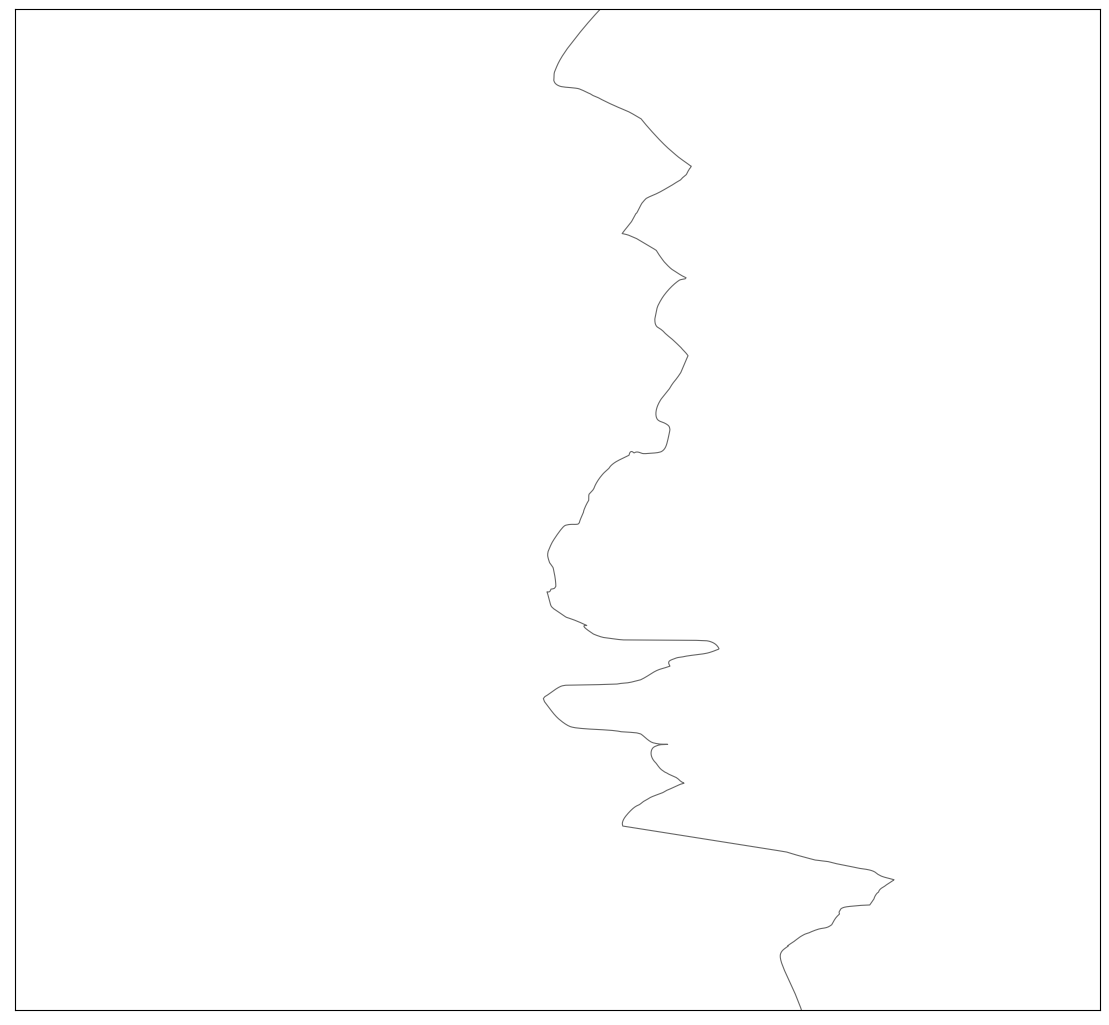

In [422]:
fig, ax = plt.subplots(1,1, figsize=(14,13))
for i in 20:20#Integer(lc_n)
    ax.plot(grid_points_normal_transformed[1,3+(i-1)*pd_n:2+i*pd_n], grid_points_normal_transformed[2,3+(i-1)*pd_n:2+i*pd_n], alpha = 0.6, color = "black", linewidth=0.8)
end
#ax.scatter(synthetic_samples[1,:], synthetic_samples[2,:], s = 0.01)
ax.set_xlim([minimum(smpls_flat_cpu[1,:])-30, maximum(smpls_flat_cpu[1,:])+30])
ax.set_ylim([minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30])
ax.get_xaxis().set_visible(false)
ax.get_yaxis().set_visible(false)

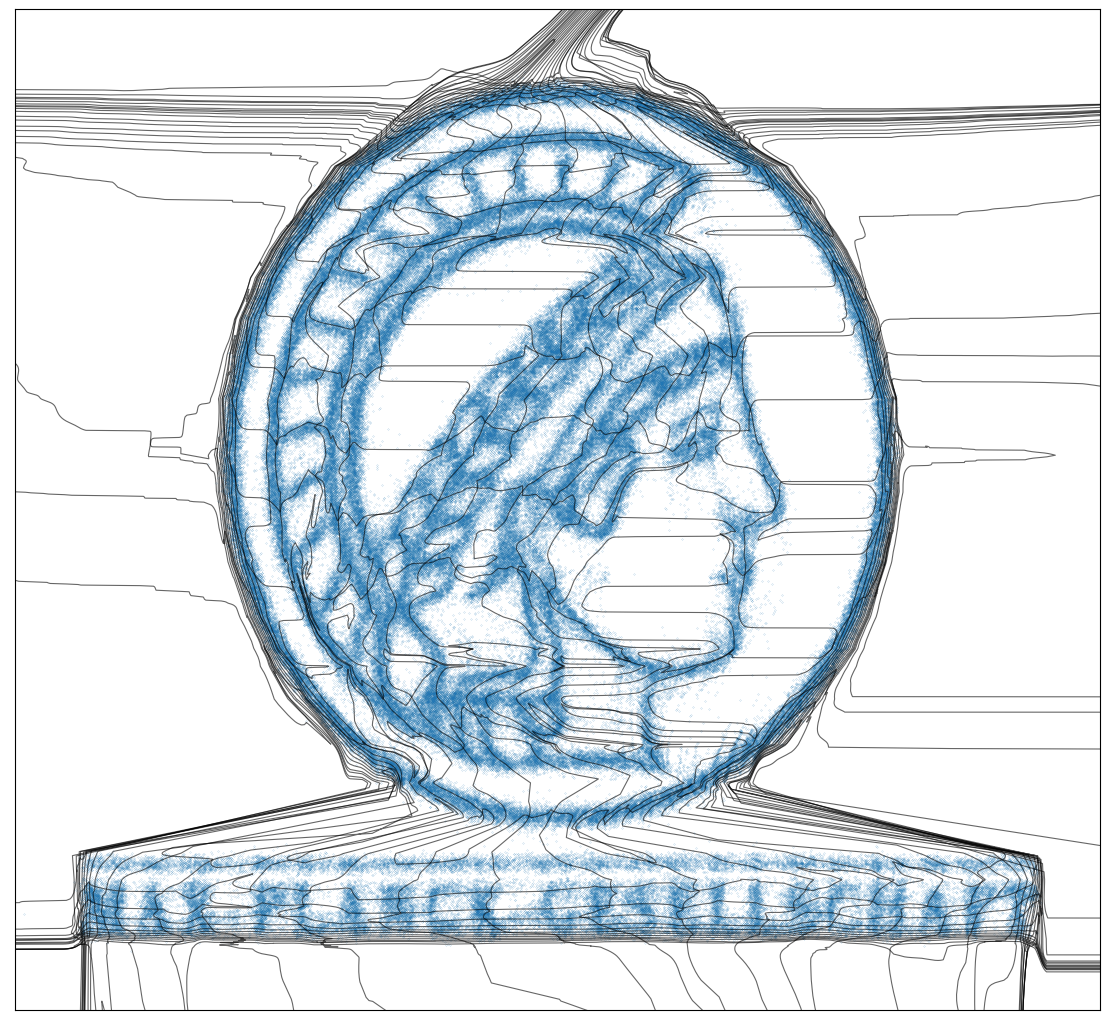

In [376]:
fig, ax = plt.subplots(1,1, figsize=(14,13))
for i in 1:Integer(lc_n)
    ax.plot(grid_points_normal_transformed[1,3+(i-1)*pd_n:2+i*pd_n], grid_points_normal_transformed[2,3+(i-1)*pd_n:2+i*pd_n], alpha = 0.6, color = "black", linewidth=0.8)
end
ax.scatter(synthetic_samples[1,:], synthetic_samples[2,:], s = 0.01)
ax.set_xlim([minimum(smpls_flat_cpu[1,:])-30, maximum(smpls_flat_cpu[1,:])+30])
ax.set_ylim([minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30])
ax.get_xaxis().set_visible(false)
ax.get_yaxis().set_visible(false)

In [387]:
Pkg.status()

Project EuclidianNormalizingFlows v0.1.0
Status `~/ACS/EuclidianNormalizingFlows.jl/Project.toml`
  [dce04be8] ArgCheck v2.3.0
⌅ [65a8f2f4] ArraysOfArrays v0.5.10
  [c0cd4b16] BAT v3.0.0-DEV `~/ACS/BAT.jl`
  [4c5d9882] BasicBSpline v0.8.2
  [052768ef] CUDA v3.12.0
  [72cfdca4] CUDAKernels v0.4.3
  [d360d2e6] ChainRulesCore v1.15.6
  [9e997f8a] ChangesOfVariables v0.1.4
⌃ [31c24e10] Distributions v0.25.64
  [ffbed154] DocStringExtensions v0.9.2
  [fdbdab4c] ElasticArrays v1.2.10
⌃ [587475ba] Flux v0.13.4
  [450a3b6d] ForwardDiffPullbacks v0.2.4
  [8e6b2b91] FunctionChains v0.1.0
⌅ [d9f16b24] Functors v0.2.8
  [09f84164] HypothesisTests v0.10.11
  [916415d5] Images v0.25.2
  [3587e190] InverseFunctions v0.1.8
  [63c18a36] KernelAbstractions v0.8.4
  [429524aa] Optim v1.7.3
⌃ [3bd65402] Optimisers v0.2.9
  [d96e819e] Parameters v0.12.3
  [276daf66] SpecialFunctions v2.1.7
  [90137ffa] StaticArrays v1.5.9
  [2913bbd2] StatsBase v0.33.21
  [136a8f8c] ValueShapes v0.10.11
  [e88e6eb3] Zygote

In [391]:
using Pkg
Pkg.add("Plots")

   Resolving package versions...
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed libfdk_aac_jll ─────────────── v2.0.2+0
   Installed Libmount_jll ───────────────── v2.35.0+0
   Installed Opus_jll ───────────────────── v1.3.2+0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.2+4
   Installed GR_jll ─────────────────────── v0.69.1+0
   Installed RelocatableFolders ─────────── v1.0.0
   Installed Measures ───────────────────── v0.3.1
   Installed Grisu ──────────────────────── v1.0.2
   Installed Contour ────────────────────── v0.6.2
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
   Installed Xorg_xcb_util_image_jll ────── v0.4.0+1
   Installed PlotUtils ──────────────────── v1.3.1
   Installed RecipesPipeline ────────────── v0.6.7
   Installed Xorg_libpthread_stubs_jll ──── v0.1.0+3
   Installed Cairo_jll ──────────────────── v1.16.1+1
   Installed Xorg_xcb_util_jll ──────────── v0.4.0+1
   Installed OpenSSL ────────────────────── v1.3.0
   Installed Fontconfig_

Precompiling project...
  ✓ Contour
  ✓ Pipe
  ✓ Measures
  ✓ Unzip
  ✓ IniFile
  ✓ URIs
  ✓ SimpleBufferStream
  ✓ UnicodeFun
  ✓ PCRE2_jll
  ✓ BitFlags
  ✓ Scratch
  ✓ OpenSSL_jll
  ✓ Graphite2_jll
  ✓ Libmount_jll
  ✓ Grisu
  ✓ fzf_jll
  ✓ Bzip2_jll
  ✓ Xorg_libXau_jll
  ✓ LAME_jll
  ✓ Ogg_jll
  ✓ Xorg_libXdmcp_jll
  ✓ x265_jll
  ✓ libfdk_aac_jll
  ✓ Pixman_jll
  ✓ x264_jll
  ✓ libaom_jll
  ✓ Expat_jll
  ✓ LZO_jll
  ✓ Opus_jll
  ✓ Xorg_xtrans_jll
  ✓ Latexify
  ✓ Libiconv_jll
  ✓ Wayland_protocols_jll
  ✓ Libgpg_error_jll
  ✓ FriBidi_jll
  ✓ Libuuid_jll
  ✓ Xorg_libpthread_stubs_jll
  ✓ RelocatableFolders
  ✓ Showoff
  ✓ Libffi_jll
  ✓ FreeType2_jll
  ✓ JLFzf
  ✓ libvorbis_jll
  ✓ Libgcrypt_jll
  ✓ XML2_jll
  ✓ OpenSSL
  ✓ Fontconfig_jll
  ✓ XSLT_jll
  ✓ Wayland_jll
  ✓ Gettext_jll
  ✓ Glib_jll
  ✓ Xorg_libxcb_jll
  ✓ Xorg_xcb_util_jll
  ✓ Xorg_libX11_jll
  ✓ Xorg_xcb_util_image_jll
  ✓ Xorg_xcb_util_keysyms_jll
  ✓ Xorg_xcb_util_wm_jll
  ✓ Xorg_libXfixes_jll
  ✓ Xorg_xcb_util_rende

In [392]:
using BasicBSpline
#using BasicBSplineExporter
using StaticArrays
using Plots

In [418]:
p1 = 2
p2 = 2
k1 = KnotVector(-10:10)+p1*KnotVector([-10,10])
k2 = KnotVector(-10:10)+p2*KnotVector([-10,10])
P1 = BSplineSpace{p1}(k1)
P2 = BSplineSpace{p2}(k2)

f(u1, u2) = SVector(2u1 + sin(u1) + cos(u2) + u2 / 2, 3u2 + sin(u2) + sin(u1) / 2 + u1^2 / 6) / 5

a = fittingcontrolpoints(f, (P1, P2))
M = BSplineManifold(a, (P1, P2))
Plots.plot(M)

LoadError: Cannot convert BSplineManifold{2, (2, 2), SVector{2, Float64}, Tuple{BSplineSpace{2, Int64}, BSplineSpace{2, Int64}}} to series data for plotting

In [417]:
k1

KnotVector([-10, -10, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10])

In [416]:
a

22×22 Matrix{SVector{2, Float64}}:
 [-5.05588, -2.50058]    [-5.06536, -2.29557]    …  [-3.05588, 9.27797]
 [-4.95087, -2.88141]    [-4.96035, -2.6764]        [-2.95087, 8.89714]
 [-4.74724, -3.57959]    [-4.75671, -3.37459]       [-2.74724, 8.19896]
 [-4.37961, -4.12911]    [-4.38909, -3.92411]       [-2.37961, 7.64944]
 [-3.81531, -4.51363]    [-3.82479, -4.30862]       [-1.81531, 7.26492]
 [-3.20658, -4.80927]    [-3.21606, -4.60426]    …  [-1.20658, 6.96928]
 [-2.74482, -5.11172]    [-2.7543, -4.90671]        [-0.744824, 6.66683]
 [-2.48703, -5.44949]    [-2.49651, -5.24448]       [-0.487032, 6.32906]
 [-2.30237, -5.75716]    [-2.31185, -5.55215]       [-0.302368, 6.02139]
 [-1.99289, -5.93575]    [-2.00237, -5.73075]       [0.00710538, 5.84279]
 [-1.47536, -5.94365]    [-1.48484, -5.73865]    …  [0.524636, 5.83489]
 [-0.857842, -5.83489]   [-0.86732, -5.62989]       [1.14216, 5.94365]
 [-0.340311, -5.70946]   [-0.349789, -5.50446]      [1.65969, 6.06909]
 [-0.0308372, -5.62139]  [

In [413]:
SVector(1,2,3)

3-element SVector{3, Int64} with indices SOneTo(3):
 1
 2
 3

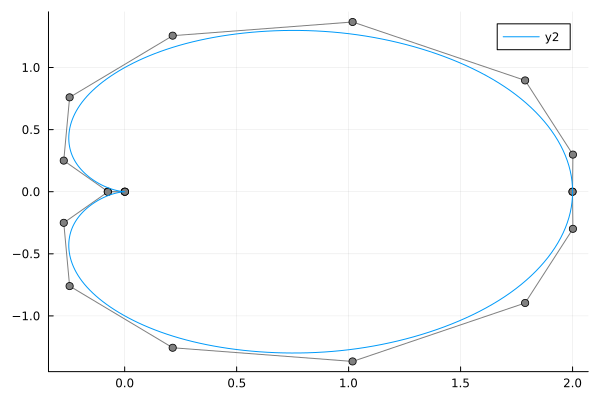

In [398]:
f(t) = SVector((1+cos(t))*cos(t),(1+cos(t))*sin(t))
p = 3
k = KnotVector(range(0,2π,15)) + p * KnotVector([0,2π]) + 2 * KnotVector([π])
P = BSplineSpace{p}(k)
a = fittingcontrolpoints(f, P)
M = BSplineManifold(a, P)

Plots.plot(M)

In [407]:
a

19-element Vector{SVector{2, Float64}}:
 [1.9997590015180606, 0.0002586481204077243]
 [2.0015083833616005, 0.298835181285283]
 [1.788116686260898, 0.8960860814400415]
 [1.0176731052593306, 1.3666845344070293]
 [0.21435955333452675, 1.2565473946695775]
 [-0.2458642610591032, 0.7599969118455053]
 [-0.27200580243640343, 0.25042953769780585]
 [-0.07533894204442518, 0.0014193036958728518]
 [0.0012247388041782513, 0.00018118879311651538]
 [-0.00020885889244785273, -1.5460722979643293e-16]
 [0.0012247388041781576, -0.0001811887931159892]
 [-0.075338942044425, -0.0014193036958728752]
 [-0.2720058024364032, -0.250429537697806]
 [-0.24586426105910397, -0.7599969118455054]
 [0.21435955333452728, -1.2565473946695773]
 [1.0176731052593284, -1.366684534407029]
 [1.7881166862609021, -0.8960860814400418]
 [2.001508383361603, -0.29883518128528336]
 [1.999759001518059, -0.00025864812040743423]

In [360]:

p = 3
k = KnotVector(range(0,2π,15)) + p * KnotVector([0,2π]) + 2 * KnotVector([π])
P = BSplineSpace{p}(k)
a = fittingcontrolpoints(f, P)
M = BSplineManifold(a, P)

Plots.plot(M)

LoadError: BoundsError: attempt to access 2×460002 Matrix{Float64} at index [1, 460003:470002]

In [440]:
lc

46

In [396]:
Plots.plot(M)

LoadError: Cannot convert BSplineManifold{2, (2, 2), SVector{2, Float64}, Tuple{BSplineSpace{2, Int64}, BSplineSpace{2, Int64}}} to series data for plotting

In [ ]:
for i in 1:Integer(lc_n)
    ax.plot(grid_points_normal_transformed[1,3+(i-1)*pd_n:2+i*pd_n], grid_points_normal_transformed[2,3+(i-1)*pd_n:2+i*pd_n], alpha = 0.6, color = "black", linewidth=0.8)
end

In [443]:
lc_n

66

In [442]:
save("/home/iwsatlas1/mdud/RQS_experiments/mpg_flow_data_with_grids.jld2", 
Dict(
"Flow" => cpu.(mpg_flow),
"Samples" => cpu(smpls_flat),
"Samples_transformed" => cpu(smpls_transformed_4),
"Grid_logo" => grid_points,
"Grid_logo_transformed" => transformed_grid_points,
"Grid_normal" => grid_points_normal,
"Grid_normal_transformed" => grid_points_normal_transformed,
"Normals" => normals_flat,
"Synthetic_Samples" => synthetic_samples
))

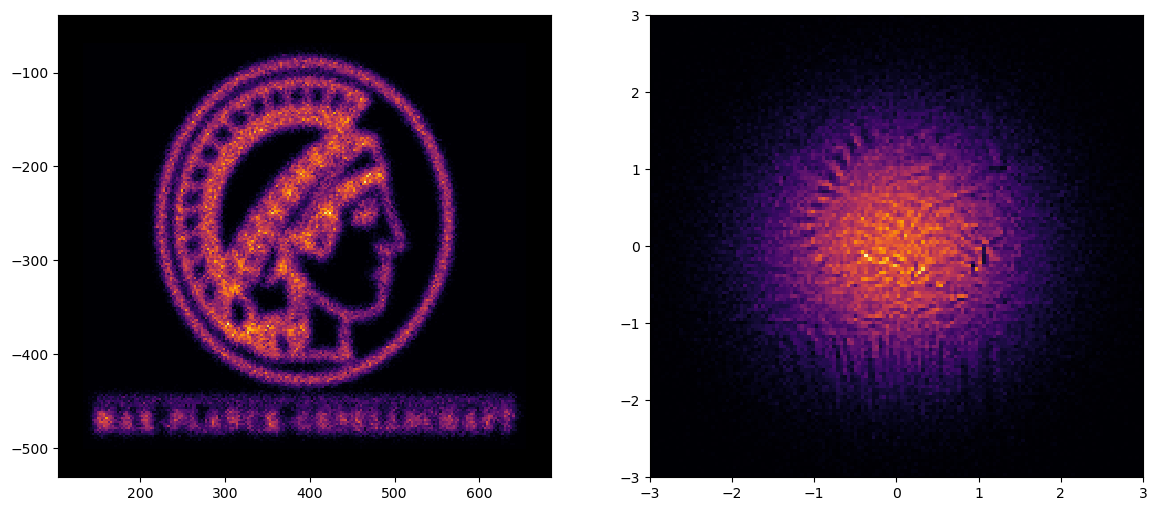

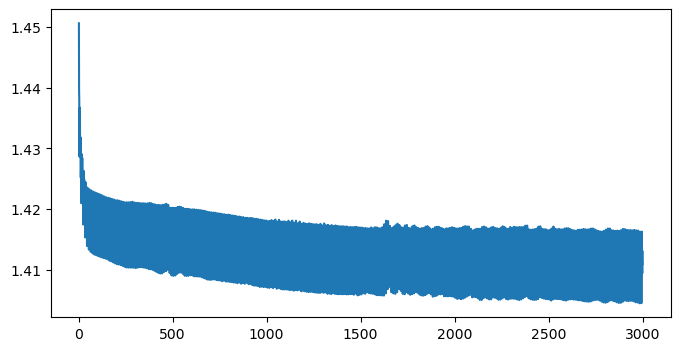

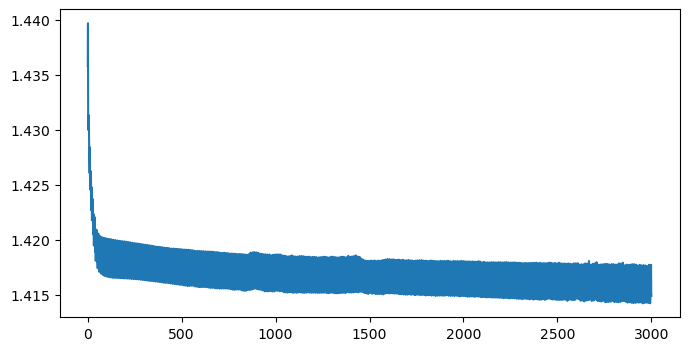

In [95]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[1].hist2d(smpls_flat_cpu[1,:], smpls_flat_cpu[2,:], [200,200], cmap="inferno")
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:])-30, maximum(smpls_flat_cpu[1,:])+30])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30])
ax[1].set_facecolor("black")
ax[2].hist2d(smpls_transformed_2[1,:], smpls_transformed_2[2,:], [200,200], cmap="inferno")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])

for i in 1:length(hists_2)
    fig2, ax2 = plt.subplots(1, figsize=(8,4))
    ax2.plot(1:length(hists_2[i]), hists_2[i])
end

In [68]:
using InverseFunctions

In [78]:
smpls_transformed = inverse(cpu(trained_flow))(randn(2,1000000))


2×1000000 Matrix{Float64}:
  401.93    479.94    274.507   371.0    …   372.486   421.833   463.958
 -346.265  -247.189  -309.012  -292.184     -144.405  -222.394  -243.917

In [12]:
smpls_transformed = trained_flow(smpls_flat)

smpls_transformed = cpu(smpls_transformed)
smpls_flat_cpu = cpu(smpls_flat)

2×95589 Matrix{Float32}:
  147.908   146.339   144.672   146.441  …   641.29    641.245   641.319
 -450.406  -450.372  -459.136  -459.473     -463.534  -464.781  -466.646

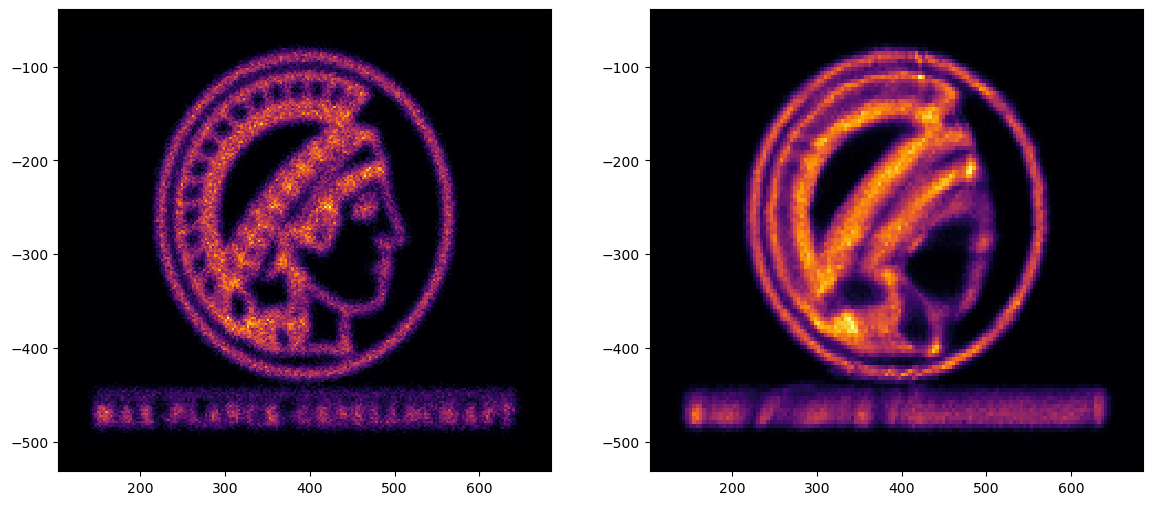

(-531.2933959960938, -39.007568359375)

In [79]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[1].hist2d(smpls_flat_cpu[1,:], smpls_flat_cpu[2,:], [200,200], cmap="inferno")
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:])-30, maximum(smpls_flat_cpu[1,:])+30])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30])
ax[1].set_facecolor("black")
ax[2].hist2d(smpls_transformed[1,:], smpls_transformed[2,:], [200,200], cmap="inferno")
ax[2].set_xlim([minimum(smpls_flat_cpu[1,:])-30, maximum(smpls_flat_cpu[1,:])+30])
ax[2].set_ylim([minimum(smpls_flat_cpu[2,:])-30, maximum(smpls_flat_cpu[2,:])+30])

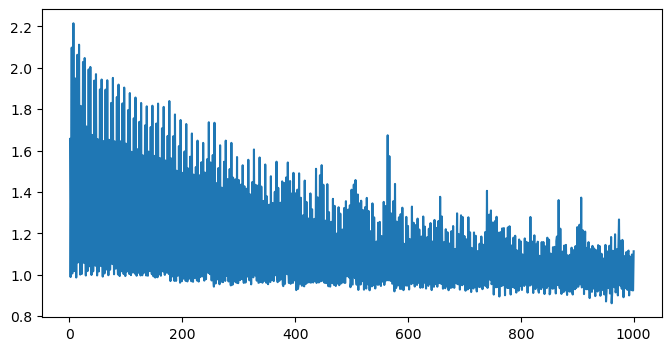

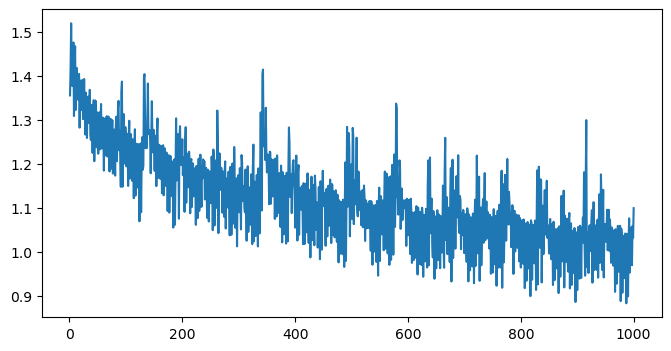

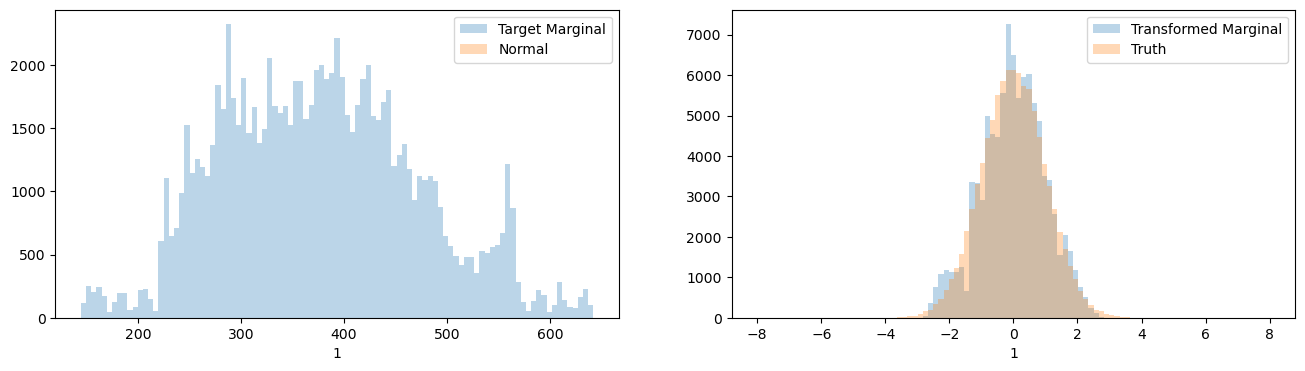

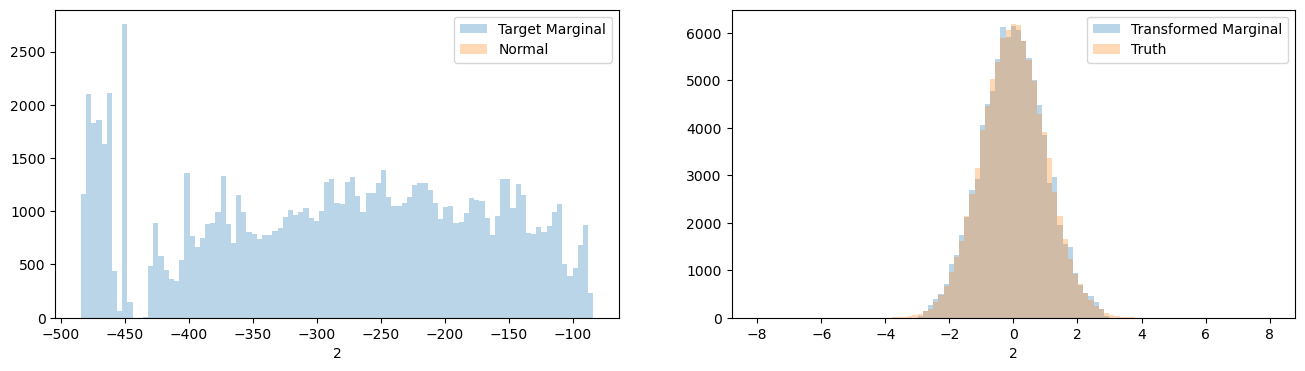

In [32]:
for i in 1:length(hists)
    fig2, ax2 = plt.subplots(1, figsize=(8,4))
    ax2.plot(1:length(hists[i]), hists[i])
end
for i in 1:size(cpu(smpls_flat),1)
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    bins = range(minimum(cpu(smpls_flat)[i,:]), maximum(cpu(smpls_flat)[i,:]), 100)
    ax[1].hist(cpu(smpls_flat)[i,:], weights=ones(size(smpls_flat,2)), bins=bins, alpha=0.3, label="Target Marginal")
    ax[1].hist(rand(Normal(), size(smpls_flat,2)),  bins=bins, alpha=0.3, label="Normal")
    ax[1].legend()
    ax[1].set_xlabel("$i")
    bins = range(-8, 8, 100)
    ax[2].hist(cpu(smpls_transformed)[i,:], weights=ones(size(smpls_flat,2)), bins=bins, alpha=0.3, label="Transformed Marginal")
    ax[2].hist(rand(Normal(), size(smpls_flat,2)),  bins=bins, alpha=0.3, label="Truth")
    ax[2].legend()
    ax[2].set_xlabel("$i")
end

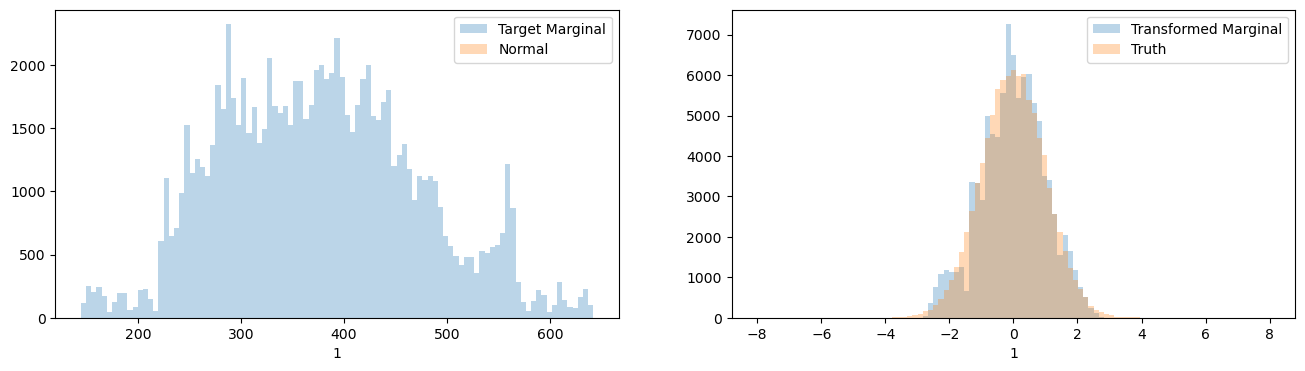

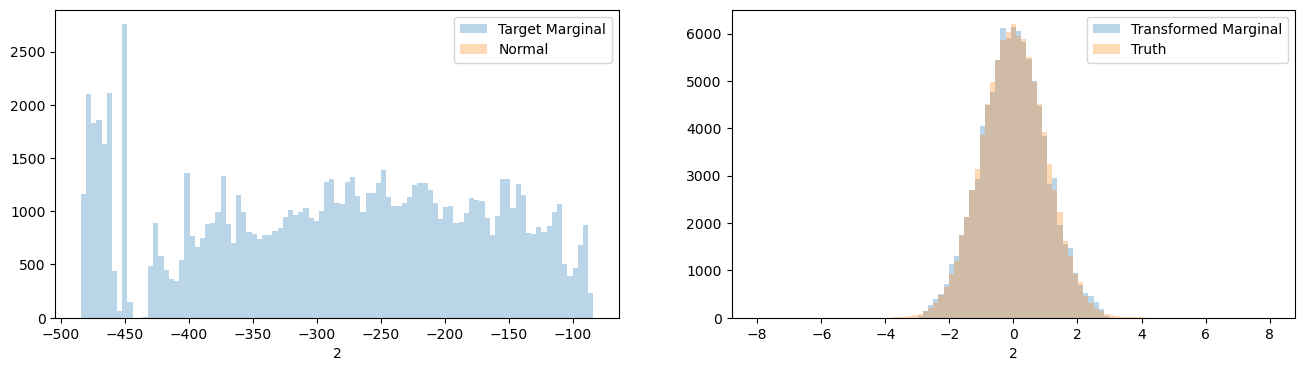

In [31]:


for i in 1:size(cpu(smpls_flat),1)
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    bins = range(minimum(cpu(smpls_flat)[i,:]), maximum(cpu(smpls_flat)[i,:]), 100)
    ax[1].hist(cpu(smpls_flat)[i,:], weights=ones(size(smpls_flat,2)), bins=bins, alpha=0.3, label="Target Marginal")
    ax[1].hist(rand(Normal(), size(smpls_flat,2)),  bins=bins, alpha=0.3, label="Normal")
    ax[1].legend()
    ax[1].set_xlabel("$i")
    bins = range(-8, 8, 100)
    ax[2].hist(cpu(smpls_transformed)[i,:], weights=ones(size(smpls_flat,2)), bins=bins, alpha=0.3, label="Transformed Marginal")
    ax[2].hist(rand(Normal(), size(smpls_flat,2)),  bins=bins, alpha=0.3, label="Truth")
    ax[2].legend()
    ax[2].set_xlabel("$i")
end